In [ ]:
!pip uninstall -y datasets
!pip install datasets==2.14.6


Found existing installation: datasets 2.14.6
Uninstalling datasets-2.14.6:
  Successfully uninstalled datasets-2.14.6
  Using cached datasets-2.14.6-py3-none-any.whl.metadata (19 kB)
Using cached datasets-2.14.6-py3-none-any.whl (493 kB)


In [ ]:
from datasets import load_dataset

ds = load_dataset("seanghay/khPOS")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments
)

# 1. Environment Setup
os.environ["WANDB_DISABLED"] = "true"
PROJECT_DIR = "/content/drive/MyDrive/Khmer_Next_Word_Prediction"
os.makedirs(PROJECT_DIR, exist_ok=True)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Data Cleaning Functions
def clean_khmer_text(text):
    # Removes underscores and tildes often found in Khmer NLP datasets
    return text.replace('_', ' ').replace('~', '')

def build_examples(example):
    tokens = example["tokens"]
    # Clean tokens and remove empty ones
    cleaned_tokens = [clean_khmer_text(t) for t in tokens if t.strip()]

    rows = []
    for i in range(1, len(cleaned_tokens)):
        context = " ".join(cleaned_tokens[:i])
        target = cleaned_tokens[i]

        # Skip symbols to focus on word prediction
        if target in ["។", "!", "?", ".", "៖"]:
            continue

        rows.append({"context": context, "next_word": target})
    return rows

# 3. Process Dataset (Assuming 'ds' is loaded)
TRUNC_ROWS = 7000
ds_trunc = ds['train'].select(range(TRUNC_ROWS))

processed_rows = []
for ex in ds_trunc:
    processed_rows.extend(build_examples(ex))

expanded_ds = Dataset.from_list(processed_rows)
split_ds = expanded_ds.train_test_split(test_size=0.1, seed=SEED)
dataset = DatasetDict({'train': split_ds['train'], 'validation': split_ds['test']})

print(f"Dataset Prepared. Total training pairs: {len(dataset['train'])}")

Dataset Prepared. Total training pairs: 59324


In [ ]:
MODEL_NAME = "goldfish-models/khm_khmr_5mb"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(device)

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

# Optimization for Next Word Prediction
tokenizer.truncation_side = 'left'
MAX_INPUT = 64

def tokenize_with_masking(batch):
    input_ids_list = []
    labels_list = []

    for c, t in zip(batch["context"], batch["next_word"]):
        # Tokenize separately to apply mask correctly
        c_ids = tokenizer.encode(c, add_special_tokens=False, truncation=True, max_length=MAX_INPUT-5)
        t_ids = tokenizer.encode(" " + t, add_special_tokens=False)

        full_ids = (c_ids + t_ids + [tokenizer.eos_token_id])[:MAX_INPUT]

        # LABEL MASKING: -100 tells the model to ignore the context in loss calculation
        label_ids = (([-100] * len(c_ids)) + t_ids + [tokenizer.eos_token_id])[:MAX_INPUT]

        input_ids_list.append(full_ids)
        labels_list.append(label_ids)

    # Pad to fixed length
    enc = tokenizer.pad({"input_ids": input_ids_list}, padding='max_length', max_length=MAX_INPUT)
    labels_dict = tokenizer.pad({"input_ids": labels_list}, padding='max_length', max_length=MAX_INPUT)

    enc["input_ids"] = torch.tensor(enc["input_ids"])
    enc["attention_mask"] = torch.tensor(enc["attention_mask"])
    labels_tensor = torch.tensor(labels_dict["input_ids"])

    # Mask the padding tokens in labels as well
    enc["labels"] = torch.where(labels_tensor == tokenizer.pad_token_id, torch.tensor(-100), labels_tensor)
    return enc



tokenized_ds = dataset.map(tokenize_with_masking, batched=True, remove_columns=dataset['train'].column_names)
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

Map:   0%|          | 0/59324 [00:00<?, ? examples/s]

You're using a AlbertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Map:   0%|          | 0/6592 [00:00<?, ? examples/s]

In [ ]:
import torch
import gc

# 1. Clear memory before starting
gc.collect()
torch.cuda.empty_cache()

# 2. Optimized Logit Preprocessing (Saves massive RAM/GPU)
def preprocess_logits_for_metrics(logits, labels):
    """
    Original logits are [batch_size, sequence_length, vocab_size].
    This converts them to [batch_size, sequence_length] immediately.
    """
    preds = torch.argmax(logits, dim=-1)
    return preds

# 3. Your Metric Function (Now receives preds directly)
def compute_metrics(eval_pred):
    # eval_pred.predictions now contains the output from preprocess_logits_for_metrics
    preds, labels = eval_pred

    # Replace -100 in labels for decoding
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    final_preds = [p.strip().split()[-1] if p.strip() else "" for p in decoded_preds]
    final_labels = [l.strip().split()[-1] if l.strip() else "" for l in decoded_labels]

    correct = sum([p == l for p, l in zip(final_preds, final_labels)])
    accuracy = correct / len(final_labels) if len(final_labels) > 0 else 0.0
    return {"accuracy": accuracy}

# 4. Final Stable Training Arguments
training_args = TrainingArguments(
    output_dir=PROJECT_DIR,
    num_train_epochs=20,
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,

    # CRITICAL MEMORY FIXES
    eval_accumulation_steps=10,
    gradient_checkpointing=True,    # Saves GPU memory during backprop
    optim="adamw_torch",            # Stable optimizer

    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    save_total_limit=1,
    load_best_model_at_end=True,
    fp16=True if torch.cuda.is_available() else False,
    report_to="none"
)

# 5. Initialize Trainer with the new Logit Preprocessor
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds['train'],
    eval_dataset=tokenized_ds['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics # ADDED THIS
)



print("Starting training with Memory Optimizations...")
trainer.train()

# Save
final_path = os.path.join(PROJECT_DIR, "final_model")
trainer.save_model(final_path)
tokenizer.save_pretrained(final_path)
print(f"Success! Model saved to {final_path}")

/tmp/ipython-input-3621593015.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Starting training with Memory Optimizations...


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.390100,1.121684,0.069933
2,0.705600,0.662186,0.073877
3,0.593100,0.582852,0.093295
4,0.508700,0.548554,0.100121
5,0.477600,0.529362,0.089958
6,0.458300,0.529748,0.099211
7,0.409600,0.513444,0.108617
8,0.392700,0.508995,0.084496


Epoch,Training Loss,Validation Loss,Accuracy
1,1.390100,1.121684,0.069933
2,0.705600,0.662186,0.073877
3,0.593100,0.582852,0.093295
4,0.508700,0.548554,0.100121
5,0.477600,0.529362,0.089958
6,0.458300,0.529748,0.099211
7,0.409600,0.513444,0.108617
8,0.392700,0.508995,0.084496
9,0.407900,0.500397,0.095874
10,0.416600,0.500495,0.110589


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Success! Model saved to /content/drive/MyDrive/Khmer_Next_Word_Prediction/final_model


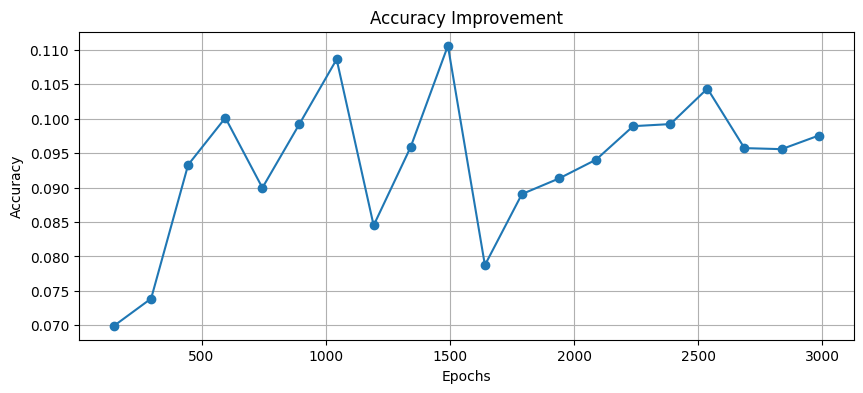

Context: ក្រៅ ពី នោះ លិខិត នេះ បាន
Prediction: បាន


In [ ]:
# 1. Plot results
df = pd.DataFrame(trainer.state.log_history)
plt.figure(figsize=(10, 4))
if 'eval_accuracy' in df.columns:
    plt.plot(df['eval_accuracy'].dropna(), label='Validation Accuracy', marker='o')
    plt.title('Accuracy Improvement')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

# 2. Manual Inference Function
def predict_next_word(context):
    model.eval()
    cleaned_ctx = clean_khmer_text(context)
    inputs = tokenizer(cleaned_ctx + " ", return_tensors='pt').to(device)

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=5,
            num_beams=10,
            repetition_penalty=1.5,
            pad_token_id=tokenizer.eos_token_id
        )

    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    prediction = generated_text[len(cleaned_ctx):].strip().split()[0] if generated_text[len(cleaned_ctx):].strip() else "..."
    return prediction

# Test a sample
sample_text = "ក្រៅ ពី នោះ លិខិត នេះ បាន"
print(f"Context: {sample_text}")
print(f"Prediction: {predict_next_word(sample_text)}")

In [ ]:
import torch
import torch.nn.functional as F
import re
import gc
from transformers import AutoTokenizer, AutoModelForCausalLM

# ======================================================
# 1. រៀបចំ Memory និងឧបករណ៍ (Setup)
# ======================================================
def setup_inference(model_path):
    gc.collect()
    torch.cuda.empty_cache()

    # Load tokenizer និង model ពី Path ដែលអ្នកបាន Save
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(model_path)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    print(f"✅ ម៉ូដែលត្រូវបាន Load ជោគជ័យលើឧបករណ៍: {device}")
    return model, tokenizer, device

# ======================================================
# 2. មុខងារជំនួយសម្រាប់ចម្រោះយកតែពាក្យខ្មែរ (Khmer Filter)
# ======================================================
def is_valid_khmer_word(word):
    if not word or len(word.strip()) == 0:
        return False
    # ឆែករកអក្សរខ្មែរ (Unicode Range: \u1780-\u17FF)
    # និងធានាថាមិនមែនជាលេខ ឬសញ្ញាដាច់ៗ
    return bool(re.search(r"[\u1780-\u17FF]", word))

# ======================================================
# 3. មុខងារទាយពាក្យបន្ទាប់ (Fixed Core Prediction)
# ======================================================
def predict_next_word_fixed(context, model, tokenizer, device, top_k=5, temperature=0.6):
    # សម្អាតចន្លោះទំនេរលើស
    context = context.strip()
    inputs = tokenizer(context, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        # យក Logits នៃ Token ចុងក្រោយបង្អស់
        logits = outputs.logits[0, -1]

    # 🔥 បិទ Special Tokens កុំឱ្យវាបង្ហាញក្នុងលទ្ធផល
    for tok_id in tokenizer.all_special_ids:
        logits[tok_id] = -float("inf")

    # ✅ អនុវត្ត Temperature Scaling ដើម្បីឱ្យ Probability កាន់តែច្បាស់លាស់
    # (ទាប = ហ្មត់ចត់/ត្រឹមត្រូវ, ខ្ពស់ = ប្លែកៗ/Creative)
    probs = F.softmax(logits / temperature, dim=-1)

    # ទាញយក Tokens មកច្រើនបន្តិច ដើម្បីទុក Filter យកតែអក្សរខ្មែរ
    top_probs, top_ids = torch.topk(probs, top_k * 5)

    valid_results = []
    for pid, p in zip(top_ids, top_probs):
        word = tokenizer.decode([pid.item()]).strip()

        if is_valid_khmer_word(word):
            valid_results.append((word, p.item() * 100))

        # បញ្ឈប់នៅពេលយើងទទួលបានចំនួនពាក្យគ្រប់តាម top_k
        if len(valid_results) == top_k:
            break

    return valid_results

# ======================================================
# 4. មុខងារបង្ហាញលទ្ធផល (Pretty Printing)
# ======================================================
def show_results(context, model, tokenizer, device, top_k=5):
    results = predict_next_word_fixed(context, model, tokenizer, device, top_k)

    print(f"\nContext: '{context}'")
    print("=" * 60)
    print(f"{'Rank':<5} | {'Candidate Word':<20} | Probability (%)")
    print("-" * 60)

    if not results:
        print("ពុំមានលទ្ធផលសមស្របត្រូវបានរកឃើញទេ។")
    else:
        for i, (word, prob) in enumerate(results, 1):
            star = "⭐" if i == 1 else ""
            print(f"#{i:<4} | {word:<20} | {prob:6.2f}% {star}")

    print("=" * 60)
    if results:
        print(f"👉 Final Choice: {results[0][0]}")

# ======================================================
# 5. ដំណើរការតេស្ត (Execution)
# ======================================================

# កំណត់ Path ទៅកាន់ម៉ូដែលរបស់អ្នក
MY_MODEL_PATH = "/content/drive/MyDrive/Khmer_Next_Word_Prediction/final_model"

# ១. រៀបចំម៉ូដែល
model, tokenizer, device = setup_inference(MY_MODEL_PATH)

test_sentences = [
    "រាជ រដ្ឋាភិបាល កម្ពុជា បាន",
    "ក្រសួង សុខាភិបាល បាន",
    "ក្រសួង អប់រំ យុវជន និង កីឡា បាន",
    "យោង តាម សេចក្តី ប្រកាស របស់",
    "យោង តាម ការ លើក ឡើង របស់",
    "ក្នុង ករណី នេះ ត្រូវ",
    "សេចក្តី ប្រកាស នេះ មាន",
    "អាជ្ញាធរ មាន សមត្ថកិច្ច បាន",
    "គណៈ រដ្ឋមន្ត្រី បាន",
    "ស្ថាប័ន នេះ មាន ភារកិច្ច"
]


for sent in test_sentences:
    show_results(sent, model, tokenizer, device, top_k=5)

✅ ម៉ូដែលត្រូវបាន Load ជោគជ័យលើឧបករណ៍: cuda

Context: 'រាជ រដ្ឋាភិបាល កម្ពុជា បាន'
Rank  | Candidate Word       | Probability (%)
------------------------------------------------------------
#1    | ការរៀបចំ             |  30.34% ⭐
#2    | ចាក                  |  12.44% 
#3    | ផ្តល់                |   5.96% 
#4    | ការផ្លាស់            |   5.28% 
#5    | កិច្ចព្រមព្រៀង       |   3.22% 
👉 Final Choice: ការរៀបចំ

Context: 'ក្រសួង សុខាភិបាល បាន'
Rank  | Candidate Word       | Probability (%)
------------------------------------------------------------
#1    | ក្រុមហ៊ុន            |  28.87% ⭐
#2    | គណៈ                  |  27.84% 
#3    | រដ្ឋាភិបាល           |   5.00% 
#4    | សម្រាប់              |   4.03% 
#5    | ក្លឹប                |   3.89% 
👉 Final Choice: ក្រុមហ៊ុន

Context: 'ក្រសួង អប់រំ យុវជន និង កីឡា បាន'
Rank  | Candidate Word       | Probability (%)
------------------------------------------------------------
#1    | ឡើង                  |  67.54% ⭐
#2    | សម្រាប់        